# Ranking Caregivers

In this note, we score caregivers' performance based on the survival of the patients they were involved in treating.   
**Assumption:** The patients are assigned to each caregiver randomly, and so there is no confounding.   
**Score Computation**: For a patient, say $pt$, we have access to the fluids and vasopressors administered at each time point and caregiver who administered the drugs. Let's say the data is as follows:  

| pt_id | timestp | cgid |
| --- | --- | --- |
| pt1 | $t_1$ | 1 |
| pt1 | $t_2$ | 2 |
| pt1 | $t_3$ | 2 |
| pt2 | $t_4$ | 1 |
| pt2 | $t_5$ | 1 |
| pt2 | $t_6$ | 3 |

Here pt_id corresponds to patient id and cgid corresponds to Caregiver id.  
If the patient $pt$ survived (/died), we will assign a score of 1 (/0) for each decision point to each caregiver, and average the scores to get a final score for each caregiver.  
In the above example, if $pt1$ survives and $pt2$ dies, the scores we get are:  

| cgid | score 
| --- | --- |
| 1 | 1/3 |
| 2 | 1 |
| 3 | 0 |


In [1]:
import pandas as pd

exportdir = '/Users/faaiz/exportdir-cg'

In [4]:
sepsis = pd.read_csv(exportdir + '/sepsis.csv')
inputMV = pd.read_csv(exportdir + '/fluid_mv.csv', sep='|')
inputCV = pd.read_csv(exportdir + '/fluid_cv.csv', sep='|')
vasoMV = pd.read_csv(exportdir + '/vaso_mv.csv', sep='|')
vasoCV = pd.read_csv(exportdir + '/vaso_cv.csv', sep='|')

In [5]:
def sepsis_onset(icustayid):
    global sepsis
    return sepsis.loc[sepsis['icustayid'] == icustayid-200000,'sepsis_time'].values[0]

In [6]:
def morta_90d(icustayid):
    global sepsis
    return sepsis.loc[sepsis['icustayid'] == icustayid-200000,'morta_90d'].values[0]

In [7]:
caregiver_info = pd.DataFrame()

caregiver_info = pd.concat([inputMV[['icustay_id', 'cgid', 'starttime']],\
                       inputCV[['icustay_id', 'cgid', 'charttime']].copy().rename(columns = {'charttime': 'starttime'}, inplace = True),\
                       vasoCV[['icustay_id', 'cgid', 'charttime']].copy().rename(columns = {'charttime': 'starttime'}, inplace = True),\
                       vasoMV[['icustay_id', 'cgid', 'starttime']]],\
                      ignore_index = True)
caregiver_info = caregiver_info.loc[(caregiver_info['icustay_id'].isin(sepsis['icustayid'] + 200000))]
# Do we want to exclude all Fluid and vasopressor inputs before sepsis onset?
# caregiver_info = caregiver_info.loc[(caregiver_info['icustay_id'].map(sepsis_onset) <= caregiver_info['starttime'])]
caregiver_info.head()

,icustay_id,cgid,starttime
0,201204,15928,4.794584e+09
1,201204,15928,4.794600e+09
2,201204,15928,4.794603e+09
3,201204,15928,4.794605e+09
4,201204,18579,4.794624e+09


In [8]:
caregiver_info['morta_90d'] = caregiver_info['icustay_id'].map(morta_90d)
caregiver_info.head()

,icustay_id,cgid,starttime,morta_90d
0,201204,15928,4.794584e+09,1.0
1,201204,15928,4.794600e+09,1.0
2,201204,15928,4.794603e+09,1.0
3,201204,15928,4.794605e+09,1.0
4,201204,18579,4.794624e+09,1.0


In [9]:
caregiver_score = caregiver_info[['cgid','morta_90d']].groupby('cgid').mean().rename(columns = {'morta_90d': 'score'}, inplace = False).sort_values(by='score', ascending=False)

caregiver_score.head()

,score
cgid,
14023,1.0
17250,1.0
19079,1.0
20622,1.0
16326,1.0


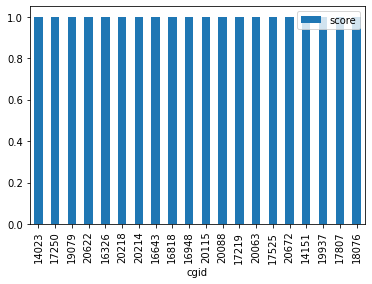

In [11]:
import matplotlib.pyplot as plt
caregiver_score.iloc[:20].plot(kind='bar')
plt.show()